# Design and simulation of superconducting co-planar waveguide resonators

## 1 - Calculating of CPW resonator properties

The equations used within this notebook and their corresponding references can be found in,

[Coplanar waveguides and superconducting resonators:
For use in hybrid Rydberg-circuit QED experiments](CPW-resonators.pdf)

### Imports

In [23]:
from scipy.special import ellipk
import math
from tabulate import tabulate
import numpy as np
import cmath

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import Image
from IPython.display import HTML, display

### Classes

In [24]:
class Conductor:
    """CPW conductor material class"""

    def __init__(self, material, criticalTemperature, londonPenetrationDepthZero, resistancePerUnitLength,
                 conductancePerUnitLength, amplitudeAttenuationPerUnitLength):
        self.material = material
        self.criticalTemperature = criticalTemperature
        self.londonPenetrationDepthZero = londonPenetrationDepthZero
        self.resistancePerUnitLength = resistancePerUnitLength
        self.conductancePerUnitLength = conductancePerUnitLength
        self.amplitudeAttenuationPerUnitLength = amplitudeAttenuationPerUnitLength

In [25]:
class Substrate:
    """Substrate material class"""

    def __init__(self, material, relativePermittivity):
        self.material = material
        self.relativePermittivity = relativePermittivity

In [26]:
class CPWResonator:
    """Coplanar wave-guide resonator class"""

    def __init__(self, length, conductorWidth, gapWidth, conductorThickness, resonatorType,
                 conductorMaterial='Niobium', substrateMaterial='Silicon',
                 temperature=4, couplingCapacitance=0E0, loadImpedance=50, loadBoundaryCondition='Short', modes=1):
        # Supplied parameters
        self.length = np.array(length)
        self.conductorWidth = np.array(conductorWidth)
        self.gapWidth = np.array(gapWidth)
        self.conductorThickness = np.array(conductorThickness)
        self.resonatorType = np.array(resonatorType)
        self.conductor = self.conductorProperties(conductorMaterial)
        self.substrate = self.substrateProperties(substrateMaterial)
        self.temperature = np.array(temperature)
        self.couplingCapacitance = np.array(couplingCapacitance)
        self.loadImpedance = np.array(loadImpedance)
        self.loadBoundaryCondition = np.array(loadBoundaryCondition)
        self.modes = np.array(modes)

        # Calculated parameters
        self.effectivePermittivity = self.effectivePermittivity(self.substrate.relativePermittivity)
        self.capacitancePerUnitLength = self.capacitancePerUnitLength(self.conductorWidth, self.gapWidth, self.effectivePermittivity)
        self.geometricInducatancePerUnitLength = self.geometricInducatancePerUnitLength(self.conductorWidth, self.gapWidth)
        self.kineticInductancePerUnitLength = self.kineticInductancePerUnitLength(self.conductorWidth, self.gapWidth, self.conductorThickness,
            self.temperature, self.conductor.criticalTemperature, self.conductor.londonPenetrationDepthZero)
        self.totalInductancePerUnitLength = self.geometricInducatancePerUnitLength + self.kineticInductancePerUnitLength
        self.characteristicImpedance = self.characteristicImpedance(self.totalInductancePerUnitLength, self.capacitancePerUnitLength)
        self.uncoupledResonantFrequency = self.uncoupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.modes)
        self.coupledResonantFrequency = self.coupledResonantFrequency(self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.length,
            self.resonatorType, self.couplingCapacitance, self.loadImpedance, self.modes)
        self.inputImpedance = self.inputImpedance(self.length, self.characteristicImpedance, self.loadBoundaryCondition,
            self.totalInductancePerUnitLength, self.capacitancePerUnitLength, self.uncoupledResonantFrequency)
        self.internalQualityFactor = self.internalQualityFactor(self.length, self.resonatorType, self.modes, self.conductor)
        self.externalQualityFactorApprox = self.externalQualityFactorApproxFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency,
            self.couplingCapacitance, self.characteristicImpedance)
        self.externalQualityFactor = self.externalQualityFactorFn(self.uncoupledResonantFrequency,
            self.capacitancePerUnitLength, self.length, self.couplingCapacitance)
        self.externalQualityFactorQWref = self.externalQualityFactorQWrefFn(self.resonatorType, self.modes, self.uncoupledResonantFrequency, self.capacitancePerUnitLength, self.length, 
            self.couplingCapacitance, self.characteristicImpedance)
        self.loadedQualityFactor = self.loadedQualityFactor(self.internalQualityFactor, self.externalQualityFactor)
        self.insertionLoss = self.insertionLoss(self.internalQualityFactor, self.externalQualityFactor)
        self.beta = self.beta(self.uncoupledResonantFrequency, self.totalInductancePerUnitLength, self.capacitancePerUnitLength)

    def effectivePermittivity(self, relativePermittivity):
        return (1 + relativePermittivity)/2

    def capacitancePerUnitLength(self, conductorWidth, gapWidth, effectivePermittivity):
        # Permittivity of free space
        freeSpacePermittivity = 8.85418782E-12

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total CPW capacitance p.u.l.
        return 4 * freeSpacePermittivity * (effectivePermittivity + 0) * (ellipk(k) / ellipk(k2))

    def geometricInducatancePerUnitLength(self, conductorWidth, gapWidth):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        k2 = np.sqrt(1 - np.power(k,2))

        # Total conductor geometric inductance p.u.l.
        return (freeSpacePermeability / 4) * (ellipk(k2) / ellipk(k))

    def kineticInductancePerUnitLength(self, conductorWidth, gapWidth, conductorThickness,
                          temperature, criticalTemperature, londonPenetrationDepthZero):
        # Permeability of freespace
        freeSpacePermeability = 1.25663706E-6

        # Complete elliptic integral of the first kind
        k = conductorWidth / (conductorWidth + 2 * gapWidth)
        K = ellipk(k)

        # Penetration depth at temperature T
        londonPenetrationDepthT = self.londonPenetrationDepthT(temperature, criticalTemperature, londonPenetrationDepthZero)

        # Geometrical factor
        geometricFactor = (1 / (2 * np.power(k, 2) * np.power(K, 2))) * (
            - np.log(conductorThickness / (4 * conductorWidth)) + ((2 * (conductorWidth + gapWidth))
            / (conductorWidth + 2 * gapWidth)) * np.log(gapWidth / (conductorWidth + gapWidth)) - (
            conductorWidth / (conductorWidth + 2 * gapWidth)) * np.log(conductorThickness
            / (4 * (conductorWidth + 2 * gapWidth))))

        # Kinetic Inductance p.u.l.
        return freeSpacePermeability * (np.power(londonPenetrationDepthT, 2) / (conductorWidth * conductorThickness)) * geometricFactor


    def londonPenetrationDepthT(self, temperature, criticalTemperature, londonPenetrationDepthZero):
        return londonPenetrationDepthZero / np.sqrt(1 - np.power((temperature / criticalTemperature), 4))

    def characteristicImpedance(self, inductance, capacitance, resistance=0, conductance=0, frequency=1):
        return np.sqrt(
            (resistance + 1j*2*math.pi*frequency*inductance ) /
            (conductance + 1j*2*math.pi*frequency*capacitance))

    def inputImpedance(self, length, characteristicImpedance, loadBoundaryCondition, inductancePerUnitLength, capacitancePerUnitLength, frequency,
                       resistancePerUnitLength=0, conductancePerUnitLength=0):
        gamma = np.sqrt(
            (resistancePerUnitLength + 1j*2*math.pi*frequency*inductancePerUnitLength ) *
            (conductancePerUnitLength + 1j*2*math.pi*frequency*capacitancePerUnitLength))

        if loadBoundaryCondition == 'Short':
            return characteristicImpedance * np.tanh(gamma*length)
        elif loadBoundaryCondition == 'Open':
            return characteristicImpedance / np.tanh(gamma * length)
        else:
            print('Error: Load boundary condition no valid!')
            return -1

    def uncoupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, modes):
        m = self.getModeFactor(resonatorType, modes)
        return 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

    def coupledResonantFrequency(self, totalInductancePerUnitLength, capacitancePerUnitLength, length, resonatorType, couplingCapacitance, loadImpedane, modes):
        m = self.getModeFactor(resonatorType, modes)

        # Pre-coupled
        uncoupledResonantFrequency = 1 / (np.sqrt(totalInductancePerUnitLength*capacitancePerUnitLength) * m * length)

        # Post-coupled
        effectiveCouplingCapacitance = self.effectiveCouplingCapacitance(couplingCapacitance, uncoupledResonantFrequency, loadImpedane)

        return 1 / (np.sqrt((totalInductancePerUnitLength*length) * ((capacitancePerUnitLength*length) + effectiveCouplingCapacitance)) * m)

    def effectiveCouplingCapacitance(self, couplingCapacitance, frequency, loadImpedane):
        return couplingCapacitance / \
               (1 + np.power(frequency * couplingCapacitance * loadImpedane * math.pi, 2))

    def internalQualityFactor(self, length, resonatorType, modes, conductor):
        m = self.getModeFactor(resonatorType, modes)
        return (1/m) * (math.pi/(conductor.amplitudeAttenuationPerUnitLength*length))
    
    def externalQualityFactorFn(self, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, loadResistance=50):
        omega_n = 2 * math.pi * uncoupledResonantFrequency
        r_star = (1+(omega_n*couplingCapacitance*loadResistance)**2) / ((omega_n*couplingCapacitance)**2 * loadResistance)
        C = (capacitancePerUnitLength * length)/2
        return omega_n * r_star * C

    def externalQualityFactorApproxFn(self, resonatorType, modes, uncoupledResonantFrequency, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        q_in = 2 * math.pi * uncoupledResonantFrequency * couplingCapacitance * characteristicImpedance
        return (1/m) * (math.pi/(q_in**2))

    def externalQualityFactorQWrefFn(self, resonatorType, modes, uncoupledResonantFrequency, capacitancePerUnitLength, length, couplingCapacitance, characteristicImpedance):
        m = self.getModeFactor(resonatorType, modes)
        omega_0 = 2 * math.pi * uncoupledResonantFrequency
        inputPortImpedance = 50
        mBody = 1/(omega_0**2 * couplingCapacitance**2 * characteristicImpedance * inputPortImpedance)
        return (math.pi/m) * mBody
    
    def loadedQualityFactor(self, internalQualityFactor, externalQualityFactor):
        return 1/((1/internalQualityFactor) + (1/externalQualityFactor))

    def getModeFactor(self, resonatorType, modes):
        if resonatorType == 'half':
            m = 4.0 / (2.0 * modes)
        elif resonatorType == 'quarter':
            m = 4.0 / ((2.0 * modes) - 1)
        else:
            print('Error: Incorrect resonator type provided!')
            return -1
        return m

    def insertionLoss(self, internalQualityFactor, externalQualityFactor):
        g = internalQualityFactor/externalQualityFactor
        return -20 * np.log10(g/(g+1))
    
    def beta(self, uncoupledResonantFrequency, inductancePerUnitLength, capacitancePerUnitLength):
        omega_n = 2 * math.pi * uncoupledResonantFrequency
        return omega_n * np.sqrt(inductancePerUnitLength*capacitancePerUnitLength)

    def conductorProperties(self, material):
        return{
            'Niobium': Conductor(material=material, criticalTemperature=9.2, londonPenetrationDepthZero=33.3E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=2.4E-4),
            'Niobium Nitride': Conductor(material=material, criticalTemperature=16.2, londonPenetrationDepthZero=40E-9,
                resistancePerUnitLength=0, conductancePerUnitLength=0, amplitudeAttenuationPerUnitLength=2.4E-4),
        }[material]

    def substrateProperties(self, material):
        return{
            'Silicon': Substrate(material=material, relativePermittivity=11.9),
            'Sapphire': Substrate(material=material, relativePermittivity=10.2),
        }[material]

## ABCD Transmission matrix

The ABCD matrix can be used to fit the transmission/reflection resonance peaks of a resonator. The matrix is defined as,

\begin{equation}
\begin{bmatrix}
    A & B \\
    C & D
\end{bmatrix}
= 
\begin{bmatrix}
    1 & Z_{in} \\
    0 & 0
\end{bmatrix}
\begin{bmatrix}
    t_{11} & t_{12} \\
    t_{21} & t_{22}
\end{bmatrix}
\begin{bmatrix}
    1 & Z_{out} \\
    0 & 0
\end{bmatrix}
\end{equation}

where, 

\begin{equation}
    t_{11} = t_{22} = \cosh{\gamma l}
\end{equation}

\begin{equation}
    t_{12} = Z_0 \sinh(\gamma l)
\end{equation}

\begin{equation}
    t_{21} = \frac{1}{Z_0} \sinh(\gamma l)
\end{equation}

where $Z_0$ is the characteristic impedance, and $\gamma = \alpha + i \beta$ where $\alpha$ is the amplitude attenuation coefficient and $\beta$ is given by,

\begin{equation}
    \beta = \frac{\omega_n}{v_{ph}} = \omega_n \sqrt{L_l C_l} = \omega_n \frac{\sqrt{\epsilon_0}}{c}
\end{equation}

The transmission parameter, $S_{21}$ is then given by,

\begin{equation}
    S_{21} = \frac{2}{A + \frac{B}{R_L} + C R_L + D}
\end{equation}

where $R_L$ is the load resistance.

In [27]:
class ABCD:
    'ABCD matrix method'

    def __init__(self, freq, length, alpha, beta, couplingCapacitance, charImpedance, loadResistance=50):
        self.freq = freq
        self.length = length
        self.gamma = alpha + 1j*beta
        self.couplingCapacitance = couplingCapacitance
        self.charImpedance = charImpedance
        self.loadResistance = loadResistance
        
        self.s21 = self.s21(self.abcd(
            self.input(self.freq, self.couplingCapacitance),
            self.transmission(self.freq, self.length, self.gamma, self.charImpedance),
            self.output(self.freq, self.couplingCapacitance)),
            self.loadResistance)

    def input(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
        
    def output(self, freq, couplingCapacitance):
        n=np.size(freq)
        Zin = 1/(1j*freq*couplingCapacitance)
        return np.append(np.ones(n),[np.zeros(n),Zin,np.ones(n)]).reshape(n,2,2,order='F')
        
    def transmission(self, freq, length, gamma, charImpedance):
        n=np.size(freq)
        t11 = np.cosh(gamma * length)
        t12 = charImpedance * np.sinh(gamma * length)
        t21 = (1/charImpedance) * np.sinh(gamma * length)
        t22 = np.cosh(gamma * length)
        return np.append(t11*np.ones(n),[t21*np.ones(n),t12*np.ones(n),t22*np.ones(n)]) \
            .reshape(n,2,2,order='F')
    
    def abcd(self, input, transmission, output):
        return input*transmission*output
    
    def s21(self, pABCD, loadResistance):
        A = pABCD[:,0,0]
        B = pABCD[:,0,1]
        C = pABCD[:,1,0]
        D = pABCD[:,1,1]
        RL = loadResistance
        return 2/( A + (B/RL)+ (C*RL) + D )

# 2 - Calculating Rydberg atom transition frequencies

The wavelength of the transition between the $n_1$th and $n_2$th levels is given by,

\begin{equation}
    \frac{1}{\lambda} = R_{M} \left( \frac{1}{n_1^2} - \frac{1}{n_1^2} \right)
\end{equation}

where $R_{M}$ is the reduced mass,

\begin{equation}
    R_{M} = \frac{R_{\infty}}{1+\frac{m_e}{M}}
\end{equation}

where $R_{\infty}$ is the Rydberg constant with an infinite mass nucleus, $m_e$ is the electron mass, and $M$ is the mass of the nucleus. $R_{\infty}$ is given by,

\begin{equation}
    R_{\infty} = \frac{m_e e^4}{8 \epsilon_0^2 h^3 c} = 1.0973731568508 \times 10^7 m^{-1}
\end{equation} 

The frequency of the transition is then,

\begin{equation}
    f = \frac{c}{\lambda}
\end{equation}

where $c$ is the speed of light.

In [28]:
class RydbergAtom:
    def __init__(self, z):
        self.z = z
        self.r_inf = 1.0973731568508 * 10**7
        
    def frequency(self, n_from, n_to):
        m_e = 9.10938356 * 10**-31
        m_p = 1.6726219 * 10**-27
        r_m = self.r_inf / (1 + (m_e/(2*self.z*m_p)))
        wavelength = 1 / ( r_m * ( (1/float(n_from)**2) - (1/float(n_to)**2) ) )
        c = 2.99792458 * 10**8
        return c / wavelength

# 3 - Relationships between CPW resonator properties

## Default values

In [29]:
default = {'length': [7208E-6],
           'conductorWidth': [20E-6],
           'gapWidth': [10E-6],
           'conductorThickness': [100E-9],
           'resonatorType': 'quarter',
           'conductorMaterial': 'Niobium Nitride',
           'substrateMaterial': 'Silicon',
           'temperature': [4],
           'couplingCapacitance': [10E-15],
           'loadBoundaryCondition': 'Short',
           'modes': [1]}    

## Lengths for $\lambda / 2$ and $\lambda / 4$ resonators

In [30]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=[1,2,3,4,5])

def length(frequency, resonatorType):
    c = 2.99792458 * 10**8
    m = mCPW.getModeFactor(resonatorType, mCPW.modes)
    return (c / np.sqrt(mCPW.effectivePermittivity)) / (m * frequency)

heliumCharge = 2
mAtom = RydbergAtom(heliumCharge)
n = 68

qwLengths = length(mAtom.frequency(n, n+1), 'quarter')
hwLengths = length(mAtom.frequency(n, n+1), 'half')
c = 2.99792458 * 10**8 

print('Transition frequency (n =', n , '->', n+1, ') is', "%.3f" % (mAtom.frequency(n, n+1)/10**9), 'GHz')

Transition frequency (n = 68 -> 69 ) is 20.470 GHz


The required lengths of the resonator (assuming no shifts due to effects of temperature, capacitive coupling, etc) such that the corresponsing harmonic matches the given frequency are summarised in Table 3.1 for both $\lambda/4$ and $\lambda/2$ resonators.

In [31]:
tableData = [['Harmonic, $n$','1','2','3','4','5'],
             ['$\lambda /4$ ($\mu$m)',*(qwLengths*10**6).astype(int)],
             ['$\lambda /2$ ($\mu$m)',*(hwLengths*10**6).astype(int)]]

display(HTML(
'<table><tr>{}</tr></table>'.format(
    '</tr><tr>'.join( 
        '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tableData)
    )
))

"Harmonic, $n$",1,2,3,4,5
$\lambda /4$ ($\mu$m),1441,4324,7208,10091,12974
$\lambda /2$ ($\mu$m),2883,5766,8649,11533,14416


<h6 align="center">Table 3.1</h6>

## Single value parameters - all properties

In [32]:
mCPW = CPWResonator(length=7153E-6, 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=3.86E-15, 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=[3])

np.set_printoptions(precision=3)
print(tabulate(
    [['Effective permittivity', mCPW.effectivePermittivity, '-'],
     ['Substrate capacitance', mCPW.capacitancePerUnitLength * 10**12, 'pF/m'],
     ['Geometric Inductance', mCPW.geometricInducatancePerUnitLength, 'H/m'],
     ['Kinetic Inductance', mCPW.kineticInductancePerUnitLength, 'H/m'],
     ['Characteristic Impedance', mCPW.characteristicImpedance, 'Ohms'],
     ['Input Impedance', mCPW.inputImpedance, 'Ohms'],
     ['Resonant frequency (Uncoupled)', mCPW.uncoupledResonantFrequency / 10**9, 'Ghz'],
     ['Resonant frequency (Coupled)', mCPW.coupledResonantFrequency / 10**9, 'Ghz'],
     ['Internal Quality factor', mCPW.internalQualityFactor, '-'],
     ['External Quality factor', mCPW.externalQualityFactor, '-'],
     ['External Quality factor [Approx]', mCPW.externalQualityFactorApprox, '-'],
     ['Loaded Quality factor', mCPW.loadedQualityFactor, '-'],
     ['Insertion loss', mCPW.insertionLoss, 'dB']],
    headers=['Property', 'Value', 'Units'], floatfmt=".2f"))

Property                          Value              Units
--------------------------------  -----------------  -------
Effective permittivity            6.45               -
Substrate capacitance             [ 173.487]         pF/m
Geometric Inductance              [  4.137e-07]      H/m
Kinetic Inductance                [  5.123e-09]      H/m
Characteristic Impedance          [ 49.132+0.j]      Ohms
Input Impedance                   [ 0. +1.605e+17j]  Ohms
Resonant frequency (Uncoupled)    [ 20.502]          Ghz
Resonant frequency (Coupled)      [ 20.47]           Ghz
Internal Quality factor           [ 2287496.398]     -
External Quality factor           [ 6469.624]        -
External Quality factor [Approx]  [ 6579.853+0.j]    -
Loaded Quality factor             [ 6451.378]        -
Insertion loss                    [ 0.025]           dB


## Multi-value parameters

### Uncoupled fundamental resonant frequency as a function of resonator length

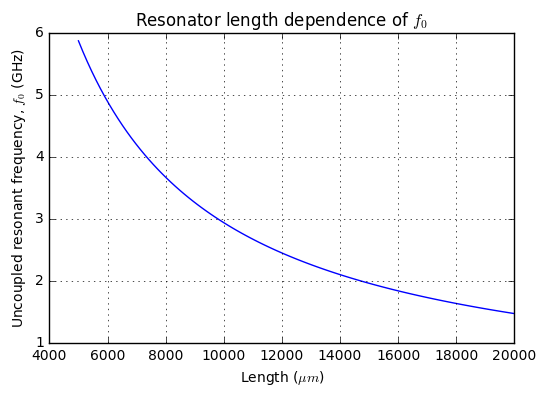

In [125]:
minLen = 5000E-6
maxLen = 20000E-6
length = np.linspace(minLen, maxLen,100)

mCPW = CPWResonator(length=length, 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(length* 10**6, mCPW.uncoupledResonantFrequency / 10**9)
plt.xlabel('Length ($\mu m$)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()
plt.title('Resonator length dependence of $f_0$')

### Uncoupled fundamental resonant frequency as a function of temperature

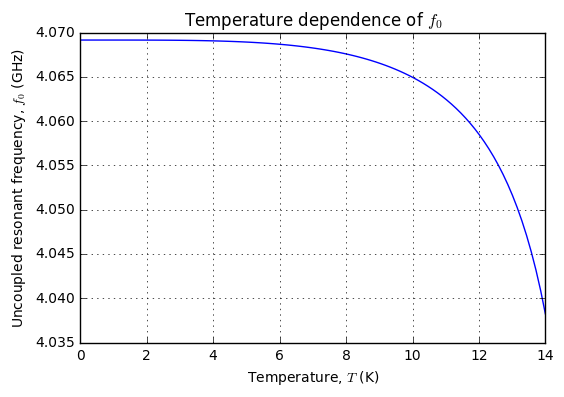

In [126]:
minTemp = 0
maxTemp = 14
temperature = np.linspace(minTemp, maxTemp,100)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=temperature, 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(temperature, mCPW.uncoupledResonantFrequency / 10**9)
plt.xlabel('Temperature, $T$ (K)')
plt.ylabel('Uncoupled resonant frequency, $f_0$ (GHz)') 
plt.grid()
plt.title('Temperature dependence of $f_0$')

### Coupled resonant frequency as a function of coupling capacitance

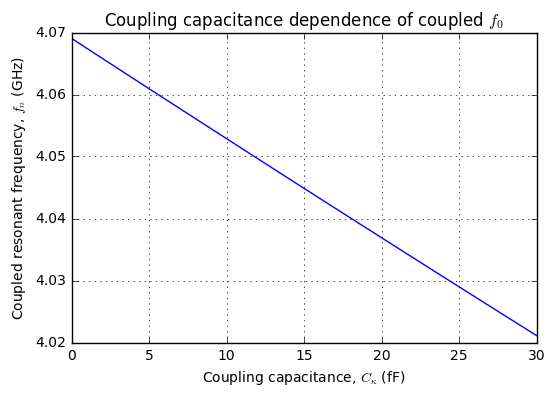

In [127]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,100)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

plt.plot(couplingCapacitance* 10**15, mCPW.coupledResonantFrequency / 10**9)
plt.xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
plt.ylabel('Coupled resonant frequency, $f_n$ (GHz)') 
plt.grid()
plt.title('Coupling capacitance dependence of coupled $f_0$')

### Loaded quality factor and insertion loss as a function of coupling capacitance

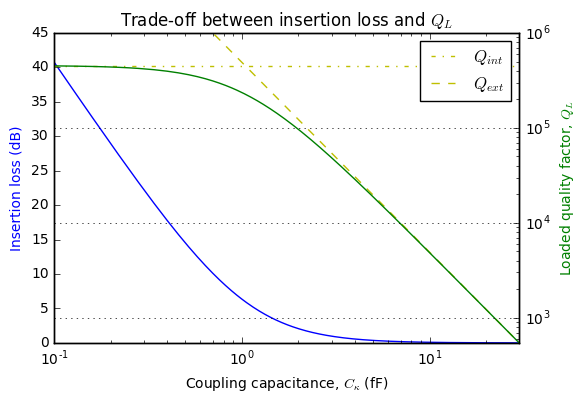

In [128]:
minCap = 0.1E-15
maxCap = 30E-15
couplingCapacitance = np.linspace(minCap, maxCap,1000)

mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=couplingCapacitance, 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

fig, ax1 = plt.subplots()
n = np.size(couplingCapacitance)
internalQualityFactor = [mCPW.internalQualityFactor]*n

ax2 = ax1.twinx()
ax2.plot(couplingCapacitance* 10**15, internalQualityFactor, 'y-.', label="$Q_{int}$")
ax2.plot(couplingCapacitance* 10**15, mCPW.externalQualityFactor, 'y--', label="$Q_{ext}$")
plt.legend()
ax1.plot(couplingCapacitance* 10**15, mCPW.insertionLoss, 'b-', label="Insertion loss")
ax2.plot(couplingCapacitance* 10**15, mCPW.loadedQualityFactor, 'g-', label="$Q_{L}$")
plt.yscale('log')

plt.xscale('log')
ax1.set_xlabel('Coupling capacitance, $C_{\kappa}$ (fF)')
ax1.set_ylabel('Insertion loss (dB)', color='b')
ax2.set_ylabel('Loaded quality factor, $Q_{L}$', color='g')
plt.xlim([0.1,30])
plt.ylim([0,10**6])
plt.grid()
plt.title('Trade-off between insertion loss and $Q_L$')

### External quality factor as a function of harmonic mode

/Users/alexmorgan/anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


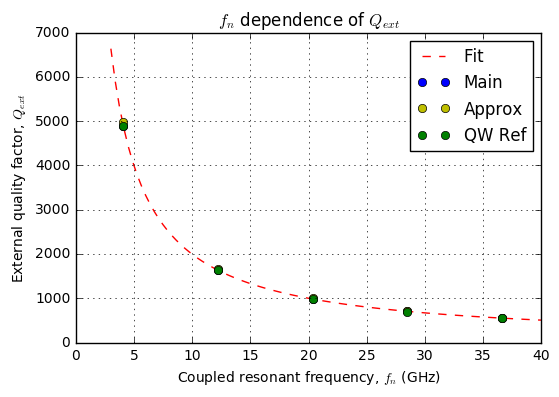

In [129]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=[1,2,3,4,5])

uncoupledResonantFrequency = np.linspace(3,40,100) * 10**9 
externalQualityFactor = mCPW.externalQualityFactorFn(uncoupledResonantFrequency, 
    mCPW.capacitancePerUnitLength, 
    mCPW.length, 
    mCPW.couplingCapacitance)

externalQualityFactorApprox = mCPW.externalQualityFactorApproxFn( mCPW.resonatorType, 
    np.array([1]), 
    uncoupledResonantFrequency, 
    mCPW.couplingCapacitance, 
    mCPW.characteristicImpedance)

plt.plot(uncoupledResonantFrequency/10**9, externalQualityFactor, 'r--', label="Fit")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactor, 'bo', label="Main")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactorApprox, 'yo', label="Approx")
plt.plot(mCPW.uncoupledResonantFrequency/10**9, mCPW.externalQualityFactorQWref, 'go', label="QW Ref")
plt.xlabel('Coupled resonant frequency, $f_n$ (GHz)')
plt.ylabel('External quality factor, $Q_{ext}$')
plt.grid()
plt.legend()
plt.title('$f_n$ dependence of $Q_{ext}$')

## ABCD matrix plots

In [130]:
mCPW = CPWResonator(length=default['length'], 
                    conductorWidth=default['conductorWidth'], 
                    gapWidth=default['gapWidth'], 
                    conductorThickness=default['conductorThickness'],
                    resonatorType=default['resonatorType'], 
                    conductorMaterial=default['conductorMaterial'], 
                    substrateMaterial=default['substrateMaterial'],
                    temperature=default['temperature'], 
                    couplingCapacitance=default['couplingCapacitance'], 
                    loadBoundaryCondition=default['loadBoundaryCondition'], 
                    modes=default['modes'])

beta=1.0E-4
freqRange=[0.1E9,400.0E9]
freqStep=0.1E9
frequency= np.arange(freqRange[0], freqRange[1], freqStep)

print('beta', mCPW.beta)

abcd=ABCD(frequency, 
          mCPW.length, 
          mCPW.conductor.amplitudeAttenuationPerUnitLength, 
          beta, # (The value of mCPW.beta is currently too high to give sensible results)
          mCPW.couplingCapacitance, 
          mCPW.characteristicImpedance)
data=abcd.s21

beta [ 217.924]


### Transmission

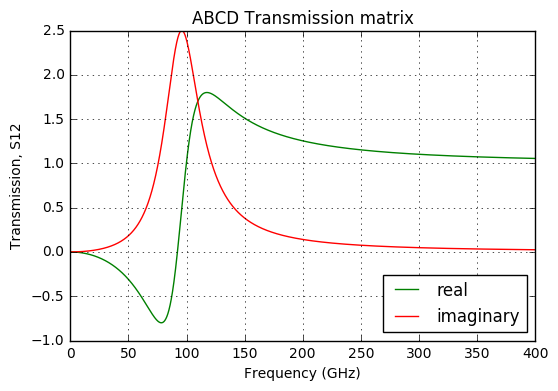

In [131]:
plt.plot(abcd.freq/10**9, np.real(data), 'g-', label='real')
plt.plot(abcd.freq/10**9, np.imag(data), 'r-', label='imaginary')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission, S12')
plt.grid()
plt.legend(loc='lower right')
plt.title('ABCD Transmission matrix')

### Reflection

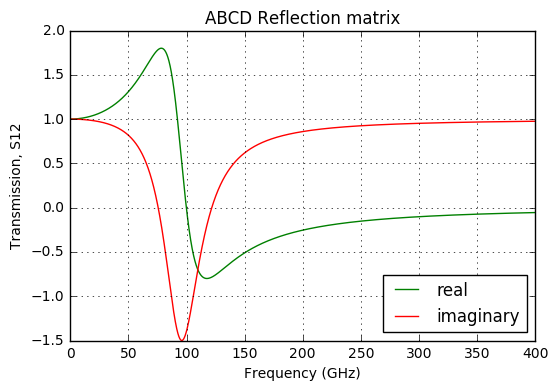

In [132]:
plt.plot(abcd.freq/10**9, 1-np.real(data), 'g-', label='real')
plt.plot(abcd.freq/10**9, 1-np.imag(data), 'r-', label='imaginary')
plt.xlabel('Frequency (GHz)')
plt.ylabel('Transmission, S12')
plt.grid()
plt.legend(loc='lower right')
plt.title('ABCD Reflection matrix')

# 4 - Simulation of CPW resonator using AWR Microwave Studio

AWR Microwave Studio is being used to analytically analyse the behaviour of an ideal quarter-wave co-planar waveguide superconducting microwave resonator. The schematic used to represent this system is shown in Figure 4.1 below,

<img src="figures/AWR_QW_schematic.png" width="600">
<h6 align="center">Figure 4.1</h6> 

The important parameters used in the model above are summarised in Table 4.1 below,

  Parameter | Value | Unit
  --- | --- | ---
  Length | 7186 | $\mu m$
  Coupling capacitance, $C_{\kappa}$ | 50 | $fF$
  Conductor width, $W$ | 20 | $\mu m$
  Gap width, $s$ | 10 | $\mu m$
  Substrate | Silicon |
  <h6 align="center">Table 4.1</h6> 

The transmission $S_{12}$ and reflection $S_{11}$ between the two ports due to the presence of the resonator is calculated as,

<img src="figures/AWR_QW_graph.png" width="600">
<h6 align="center">Figure 4.2</h6> 

This leaves two pieces of the puzzle left,
- What value should be used for the coupling capacitance, $C_{\kappa}$ 
- How to design a coupler with this capacitance

The answer to the former comes down to a trade-off between external quality factor and insertion loss, as seen in one of the figures above. The range of obtainable coupling capacitances is also limited by fabrication restrictions. For example the minimum feature size of photo-lithogrpahy will be around 2-5 $\mu m$ which with a coupler length of 300 $\mu m$ leads to a coupling capacitance of 8-10 $fF$ (as discussed in the next section). Therefore in order to increase the coupling capacitance beyond these values the length of the coupler will need to be increased. However this is also limited because this length should be much less than $\lambda /4$.

## Calculation of coupling capacitance using CST EM Studio

In order to design a coupler with a desired capacitance, it is necessary to use a finite element similuation such as CST EM studio. Below we summarise the results.

The geometry used to simulate the coupling capacitance is illustrated in Figure 4.3 below,

<img src="figures/CST_QW_geometry.png" width="600">
<h6 align="center">Figure 4.3</h6> 

Electric potentials +1 and -1 were applied to the feedline and resonator respectively. These values were arbitrary and were only set because this is the only way in which I could seem to extract a capacitance matrix. The ground plane was left unassigned and is by default used as the ground reference.

The two variables in this geomtery are the length of the coupler and the width of the gap between the feedline and resonator. Table 4.2 below summarises the capacitances calculated within this parameter space. The capacitances are stated in units of $fF$.


$\textbf{Coupler length}$ ($\mu m$) |  $\textbf{2 $\mu m$ separation}$ |  $\textbf{5 $\mu m$ separation}$ |  $\textbf{10 $\mu m$ separation}$ |  $\textbf{20 $\mu m$ separation}$
--- | --- | ---
$\textbf{100}$ (extrapolated) | 4.63 | 3.86 | 2.97 | 2.00
$\textbf{200}$ | 7.37 | 5.99 | 4.55 | 3.00
$\textbf{300}$ | 10.14 | 8.14 | 6.14 | 4.01
$\textbf{400}$ | 12.86 | 10.26 | 7.72 | 5.00

<h6 align="center">Table 4.2</h6> 

The atoms will couple to the electric field of the resonator. Although the e-field is zero at the grounded end of the resonator, this won't be an issue because we plan to use a higher harmonic mode therefore an e-field maxiumum will be present along the interaction length of the resonator, as shown in Figure 4.4 below,

<img src="figures/CST_QW_e-field.png" width="600">
<h6 align="center">Figure 4.4</h6> 

# 5 - Design parameters

## 5.1 - Design 1 - Square tiles

An illustration of the design of the entire chip (in fact the mask) is shown in Figure 5.1 below,

<img src="figures/mask-design-single.png" width="600">
<h6 align="center">Figure 5.1</h6>

The feedline is terminated with pad that maintain the ratio of the conductor to the gap in order to maintain an impedance of 50 $\Omega$ and hence minimise reflections. The pads allow wire bonds to connect the chip to a PCB.

The parameters describing the unit ceel resonator are summarised in Tables 5.1 below,

  Parameter | Value | Unit
  --- | --- | ---
  Chip dimensions | 10x10 | $mm^2$
  Feedline conductor width | 20 | $\mu m$
  Feedline gap width | 10 | $\mu m$
  Feedline vertical length | 2840 | $\mu m$
  Feedline horiztonal length | 6160 | $\mu m$
  Feedline curve inner radius | 100 | $\mu m$
  Pad conductor width | 300 | $\mu m$
  Pad gap width | 150 | $\mu m$
  Pad expansion length | 610 | $\mu m$
  Resonator conductor width | 20 | $\mu m$
  Resonator gap width | 10 | $\mu m$
  Resonator curve inner radius | 100 | $\mu m$
  Resonator vertical length | 2000 | $\mu m$
  Resonator interaction length | variable |
  Resonator coupler length | variable | 
  Resonator total length | variable |
  Coupler-feedline separation (gap width) | variable |
  <h6 align="center">Table 5.1 - Fixed physical dimensions</h6> 

The wafers being used have a diameter of 4 inches. With 10x10 $mm$ tiles and an inter-tile spacing of 200 $\mu m$ gives the following layout,

<img src="figures/mask-design-wafer.png" width="600">
<h6 align="center">Figure 5.2</h6>

  Parameter | Value | Unit
  --- | --- | ---
  Diameter of wafer | 4 (100) | inch ($mm$)
  Size of mask | 5x5 | inch$^2$
  Number of tiles available | 44 |
  Redundancy | 2 |
  Number of unique designs | 22 |
  <h6 align="center">Table 5.2 - Number of designs</h6> 
  
  Parameter | Value | Unit
  --- | --- | ---
  Conductor material | Niobium Nitride |
  Conductor thickness | 100 | $nm$
  Substrate material | Silicon |
  Substrate thickness | 500 | $\mu m$
  <h6 align="center">Table 5.3 - Other resonator properties</h6> 

Given the variable parameters highlighted in Table 5.1, below are the set of parameters chosen for each design.

  \# | Coupler length, $\mu m$ | Coupler-feedline, $\mu m$ | $C_{\kappa}$, $fF$ | Transition, $n\rightarrow n+1$ | $f_0$, GHz | Total length, $\mu m$ | Interaction length, $\mu m$ | $Q_{ext}$
  ---| 
  1  | 200 | 20 | 3.00  | 66 | 22.373 | 6546 | 3850 | 8968
  2  | 200 | 10 | 4.55  | 66 | 22.373 | 6542 | 3846 | 3893
  3  | 200 | 5  | 5.99  | 66 | 22.373 | 6538 | 3842 | 2246 
  4  | 300 | 20 | 4.01  | 66 | 22.373 | 6543 | 3847 | 5016
  5  | 300 | 10 | 6.14  | 66 | 22.373 | 6538 | 3842 | 2138 
  6  | 300 | 5  | 8.14  | 66 | 22.373 | 6531 | 3835 | 1215 
  7  | 400 | 20 | 5.00  | 66 | 22.373 | 6540 | 3844 | 3325
  8  | 400 | 10 | 7.72  | 66 | 22.373 | 6533 | 3837 | 1352  
  9  | 400 | 5  | 10.26 | 66 | 22.373 | 6526 | 3830 | 766
  10 | 200 | 20 | 3.00  | 68 | 20.470 | 7155 | 4459 | 10714
  11 | 200 | 10 | 4.55  | 68 | 20.470 | 7151 | 4455 | 4650  
  12 | 200 | 5  | 5.99  | 68 | 20.470 | 7147 | 4451 | 2684  
  13 | 300 | 20 | 4.01  | 68 | 20.470 | 7152 | 4456 | 5993
  14 | 300 | 10 | 6.14  | 68 | 20.470 | 7146 | 4450 | 2554  
  15 | 300 | 5  | 8.14  | 68 | 20.470 | 7141 | 4445 | 1453  
  16 | 400 | 20 | 5.00  | 68 | 20.470 | 7149 | 4453 | 3853
  17 | 400 | 10 | 7.72  | 68 | 20.470 | 7142 | 4446 | 1615  
  18 | 400 | 5  | 10.26 | 68 | 20.470 | 7135 | 4439 | 914  
  19 | 200 | 20 | 3.00  | 70 | 18.777 | 7801 | 5103 | 12735
  20 | 200 | 10 | 4.55  | 70 | 18.777 | 7800 | 5102 | 5537  
  21 | 200 | 5  | 5.99  | 70 | 18.777 | 7793 | 5095 | 3190 
  22 | 300 | 20 | 4.01  | 70 | 18.777 | 7798 | 5100 | 7124
  23 | 300 | 10 | 6.14  | 70 | 18.777 | 7792 | 5094 | 3036  
  24 | 300 | 5  | 8.14  | 70 | 18.777 | 7786 | 5090 | 1726 
  25 | 400 | 20 | 5.00  | 70 | 18.777 | 7796 | 5098 | 4581
  26 | 400 | 10 | 7.72  | 70 | 18.777 | 7788 | 5092 | 1920  
  27 | 400 | 5  | 10.26 | 70 | 18.777 | 7780 | 5084 | 1087 
  <h6 align="center">Table 5.4 - Design parameters</h6> 

## 5.2 - Design 2 - Larger tiles

An issue with the previous design is that the resonator is quite close to the edges of the chip and hence also close to the wire bonds. These will radiate uncontrollable and unknown stray electric fields which will have detrimental effects for the experiment. To overcome this issue, it is possible to increase the size of the chip, in either axis or both. The trade-off here is that a larger chip is more likely to support unwanted extra modes as the distant to a ground wire bond is increased. As the outcome of increasing the chip size is unknown, multiple chip dimensions will be included in the mask.

The new proposed mask is illustrated in Figure 5.3 below. As well as changing the chip dimensions, the vertical length of the feedline have been updated such that the interaction section of the resonator is in the middle of the chip in the vertical sense.

<img src="figures/mask-design-wafer-2.png" width="600">
<h6 align="center">Figure 5.3</h6>

The range of chip dimensions, and number of each are summaried in Table 5.5 below,

  Horiztonal dimension, $mm$ | Vertical dimension, $mm$  | Number available
  ---| 
  10 | 10 | 4
  10 | 20 | 8
  20 | 10 | 8
  20 | 20 | 4
  
  <h6 align="center">Table 5.5 - Chip dimensions and availability</h6> 

Given the reduction in the number of available design, it makes more sense to remove the variation in $n$, the Rydberg transition. We therefore choose $n=68$ with a corresponing $f_0 = 20.470$ GHz. As before the set of chosen parameters are shown in Table 5.6,

  Label (M(ask)\_:C(hip)\_) | $L_{coupler}$, $\mu m$ | $L_{coupler-feedline}$, $\mu m$ | $C_{\kappa}$, $fF$ | $L_{total}$, $\mu m$ (geom) | $L_{vert}$, $\mu m$ | $L_{int}$, $\mu m$ | $L_{total}$, $\mu m$ (macro) | $Q_{ext}$
  ---| 
  M1:C(01-06) | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 7173 | 6470
  M1:C(07-12) | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 7167 | 2684
  M1:C(13-18) | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 7161 | 1453
  M1:C(19-24) | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 7155 | 914
  <h6 align="center">Table 5.6 - Design parameters</h6>

Each of the four designs are to be used with 4 different chip sizes with the corresponding redundancies, 10x10$mm$ (x1), 10x20$mm$ (x2), 20x10$mm$ (x2), 20x20$mm$ (x1). A label will be applied to each mask so that it can be identified post fabrication. The format is Mx:Cxx (for example M1:C08 for the 8th chip of 1st mask design). For clarification Table 5.7 shows the unique labelling.

  Label (M(ask)\_:C(hip)\_) | $L_{coupler}$, $\mu m$ | $L_{coupler-feedline}$, $\mu m$ | $C_{\kappa}$, $fF$ | $L_{total}$, $\mu m$ (geom) | $L_{vert}$, $\mu m$ | $L_{int}$, $\mu m$ | $Q_{ext}$ | Chip dimension, WxH ($mm^2$)
  ---| 
  M1:C01 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 10x10
  M1:C02 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 10x20
  M1:C03 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 10x20
  M1:C04 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 20x10
  M1:C05 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 20x10
  M1:C06 | 100 | 5  | 3.86  | 7153 | 2000 | 4676 | 6470 | 20x20 
  M1:C07 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 10x10
  M1:C08 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 10x20
  M1:C09 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 10x20
  M1:C10 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 20x10
  M1:C11 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 20x10
  M1:C12 | 200 | 5  | 5.99  | 7147 | 2000 | 4570 | 2684 | 20x20
  M1:C13 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 10x10
  M1:C14 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 10x20
  M1:C15 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 10x20
  M1:C16 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 20x10
  M1:C17 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 20x10
  M1:C18 | 300 | 5  | 8.14  | 7141 | 2000 | 4464 | 1453 | 20x20
  M1:C19 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 10x10
  M1:C20 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 10x20
  M1:C21 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 10x20
  M1:C22 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 20x10
  M1:C23 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 20x10
  M1:C24 | 400 | 5  | 10.26 | 7135 | 2000 | 4358 | 914  | 20x20
  <h6 align="center">Table 5.7 - Design labels</h6>

The tile number is as follows,

<img src="masks/illustrations/tile-numbering.png" width="400">
<h6 align="center">Figure 5.4 - Tile numbering for design 2</h6>

## 5.3 - Calculating the length of a $\lambda$/4 resonator

I've found a macro for KLayout which attempts to calculate the length of a polygon (and by extension of a resonator) by using the perimeter length. The macro is,

The output of which looks something like,

In order to design a resontor of the desired length I could either use this tool or try to calculate it myself from geometrical considerations. For comparative purposes I'll do both. The follow code attempts such a geomertic calculation.

In [5]:
# Length of curved section
#   CPW properties
cpwCond = 20
cpwGap  = 10
#   Radius of curvation (inner part)
curveInnerRadius = 100
#   Radius of curvation (centre of conductor)
curveMidRadius = curveInnerRadius + cpwGap + (cpwCond/2)
#   Length of quarter-circle curved section
curvedLen = (2 * math.pi * curveMidRadius) / 4

In [6]:
# Other resonator component lengths
#   Coupler
couplerLen = 200
#   Interaction
interactionLen = 5000
#   Vertical
verticalLen = 1755

# Resonator length
resonatorLen = couplerLen + interactionLen + verticalLen + (2*curvedLen)
print('Resonator length: {0:.2f} um'.format(resonatorLen))

Resonator length: 7331.99 um


It's also useful to be able to specific the total length which you want and have code to tell you how long the interaction section should, given that the interaction-feedline seperation should be kept constant. (uses variables from previous cell)

In [21]:
# Total resonator length
resonatorLen = 7153
# Coupler length
couplerLen = 100
# Interaction section separation from the feedline
interactionFeedlineSep = 2245

# Coupler section separation from the feedline
couplerFeedlineSep = 5
# Vertical length
verticalLen = interactionFeedlineSep - (couplerFeedlineSep + 2*cpwGap + cpwCond + 2*curveInnerRadius)
print('Vertical length: {0:.2f} um'.format(verticalLen))

# Calculated interaction length
interactionLen = resonatorLen - (verticalLen + couplerLen + 2*curvedLen)
print('Interaction length: {0:.2f} um'.format(interactionLen))

Vertical length: 2000.00 um
Interaction length: 4676.01 um
